In [3]:
#Add libPaths to allow R to find packages installed through command line with miniconda
.libPaths('/hb/home/jbos/.conda/envs/vcfR')
.libPaths("/hb/home/jbos/.conda/envs/vcfR/lib/R/library")
.libPaths()

[1] "/hb/home/jbos/.conda/envs/vcfR/lib/R/library"  
[2] "/hb/software/apps/r/conda3-4.4.1/lib/R/library"

In [5]:
#Load packages
library(ncdf4)
library(raster)
library(tidyverse)
library(sf)
library(vegan)
library(adegenet)
library(hierfstat)
library(tidyverse)
library(vcfR)
library(viridis)

In [6]:
#Function to find the nearest release site by great circle distance to a specific sampling site
mindist_match<-function(sampling_i,release_all){
    d<-st_distance(sampling_i$coords,release_all$coords)
    return(release_all$release_flat[d==min(d)])
    }

In [7]:
#Calculate great circle distances from lat/lons
wide_dists <- function(sites){
    x<-st_as_sf(sites,coords=c('lon_flat','lat_flat'))
    x<-st_set_crs(x,4326)
    d <- st_distance(x)
    colnames(d)<-sites$release_flat
    rownames(d)<-sites$release_flat
    d<-as.data.frame(d)
    return(d)
}

In [8]:
#Function to create long form dataset containing pairwise FSTs and corresponding release sites.
#Note that due to differing spatial grains multiple pairwise FST values will correspond to each release site pair!
fst_transform<-function(fsts,sitesA,sitesB){
    colnames(fsts)[1]<-'siteA'
    fst_long<-pivot_longer(fsts,cols=colnames(fsts)[2:length(colnames(fsts))],names_to='siteB',values_to='fst')
    colnames(fst_long)<-c('siteA','siteB','fst')
    fst_long<-fst_long[!is.nan(fst_long$fst),]
    fst_long<-left_join(fst_long,sitesA,by='siteA')
    fst_long<-left_join(fst_long,sitesB,by='siteB')
    fst_long$release<-paste(fst_long$release_siteA,fst_long$release_siteB)
    return(fst_long)
}

In [9]:
#Function to join long form FSTs and long form connectivity data
fst_oceanography<-function(fsts,connectivity){
    fsts<-fsts[,c('siteA','siteB','fst','release')]
    fsts<-left_join(fsts,connectivity,by='release')
    fsts<-fsts[!is.na(fsts$fst),]
    return(fsts)
    }

In [10]:
#Function to convert connectivity data to wide form for Mantel test
wide_ocean<-function(fst_ocean){
    x<-fst_ocean[,c('siteA','siteB','connectivity')]
    y<-as.data.frame(pivot_wider(x,id_cols='siteA',names_from='siteB',values_from='connectivity'))
    rownames(y)<-y$siteA
    y<-y[,!(colnames(y)=='siteA')]
    last<-ncol(y)
    y<-y[,c(last,seq(1,(last-1),1))]
    return(y)
    }

In [11]:
#Function to convert FST data to wide form for Mantel test
wide_fst<-function(fst_ocean){
    x<-fst_ocean[,c('siteA','siteB','fst')]
    y<-as.data.frame(pivot_wider(x,id_cols='siteA',names_from='siteB',values_from='fst'))
    rownames(y)<-y$siteA
    y<-y[,!(colnames(y)=='siteA')]
    last<-ncol(y)
    y<-y[,c(last,seq(1,(last-1),1))]
    return(as.data.frame(y))
    }

In [12]:
#Function to average upper and lower triangles of a matrix - this is necessary because connectivity data is not symmetrical
matavg<-function(matr){
    a<-matr
    b<-t(matr)
    return(0.5*(a+b))
    }

In [13]:
#Function to create a 1d vector of release site names from a 1d vector of sampling site names
popmap<-function(sites){
    dict<-site_dict[site_dict$Name %in% sites,]
    for (i in 1:nrow(dict)){
        sites<-gsub(dict[i,1],dict[i,2],sites)
        }
    return(as.factor(sites))
    }

In [14]:
#Function to convert connectivity data to wide form for Mantel test
con_trans2<-function(pop){
    c<-con_long[con_long$release_siteA %in% pop,]
    c<-c[c$release_siteB %in% pop,c('release_siteA','release_siteB','connectivity')]
    c<-as.data.frame(pivot_wider(c,id_cols='release_siteA',names_from='release_siteB',values_from='connectivity'))
    rownames(c)<-c$release_siteA
    c<-c[,!(colnames(c)=='release_siteA')]
    return(c)
    }

In [15]:
#Function to convert wide form fst and oceanographic connectivity back to long form and add a mean individuals per pop column
long_again<-function(widefst,wideocean,indpops){
    a<-as.data.frame(widefst)
    a$siteA<-rownames(a)
    a<-pivot_longer(a,cols=colnames(a)[1:(ncol(a)-1)],names_to="siteB",values_to="fst")
    b<-as.data.frame(wideocean)
    b$siteA<-rownames(b)
    b<-pivot_longer(b,cols=colnames(b)[1:(ncol(b)-1)],names_to="siteB",values_to="connectivity")
    c<-inner_join(a,b)
    dum<-as.data.frame(table(indpops$Population))
    colnames(dum)<-c('siteA','siteA_counts')
    c<-left_join(c,dum,by='siteA')
    colnames(dum)<-c('siteB','siteB_counts')
    c<-left_join(c,dum,by='siteB')
    c$mean_counts<-rowMeans(as.data.frame(cbind(c$siteA_counts,c$siteB_counts)))
    return(c)
        }

In [57]:
#Input: all release sites, FSTs for given taxa
#Output: wide distances aggregated to grain of release sites
wide_release<-function(rc,fsts,release_flat){
    rc <- rc[rc[,3] %in% colnames(fsts),]
    agg<-rc[,1:3] %>% group_by(release_flat) %>% summarise_all(mean)
    wide_dists1<-wide_dists(agg)
    return(wide_dists1)
    }

In [16]:
#Open netcdf containing 10 day historical connectivity data
c10d<-nc_open("CORAL-connect_25_historical_pconnect_10-day_noedges2.nc")
#print(c10d)

In [17]:
#Open netcdf containing 30 day historical connectivity data
c30d<-nc_open("/hb/scratch/jbos/CORAL-connect_25_Spring-Fallhistorical_pconnect_30-day.nc")
print(c30d)

File /hb/scratch/jbos/CORAL-connect_25_Spring-Fallhistorical_pconnect_30-day.nc (NC_FORMAT_64BIT):

     1 variables (excluding dimension variables):
        double pconnect[dst_site,src_site]   
            long_name: Potential Connectivity

     2 dimensions:
        src_site  Size:2947 (no dimvar)
        dst_site  Size:2947 (no dimvar)

    3 global attributes:
        Description: Potential Connectivity for a 30 days pelagic larval duration in the Indonesian Archipelago
        Created: 2014-10-09 19:25:35
        title: Potential Connectivity


In [18]:
#Pull out connectivity specifically and convert to a dataframe; check dimensions
connect_data <- as.data.frame(ncvar_get(c30d, varid="pconnect")) 
dim(connect_data)

[1] 2947 2947

In [19]:
#Metadata for the release sites used in the connectivity matrix, in netcdf form
#Note that the connectivity data comes from a ROMS model and are defined in terms of xi_rho and eta_rho, rather than lat/lon
#This netcdf contains lon data corresponding to each xi_rho/eta_rho pair, lat data corresponding to each xi_rho/eta_rho pair
#And a matrix of all xi_rho and eta_rho pairs, with release site numbers as the values. 
#Most values are zero since most coordinate pairs don't correspond to release sites!
release_data <- nc_open("coral_all_release_site_coarse.nc")
print(release_data)

File coral_all_release_site_coarse.nc (NC_FORMAT_64BIT):

     3 variables (excluding dimension variables):
        double lon[xi_rho,eta_rho]   
            long_name: longitude
            units: degree_east
        double lat[xi_rho,eta_rho]   
            long_name: latitude
            units: degree_north
        float release_site[xi_rho,eta_rho]   
            _FillValue: 1.00000002004088e+20
            long_name: release site flag
            units: None
            valid_min: 1
            valid_max: 2947

     2 dimensions:
        xi_rho  Size:1282 (no dimvar)
        eta_rho  Size:642 (no dimvar)

    3 global attributes:
        Description: release sites and associated eco-regions
        Created: 2014-07-18 16:09:23
        title: Release site locations


In [20]:
#Get longitudes and latitudes corresponding to each xi_rho/eta_rho (ROMS model) coordinate pair
lon_data <- ncvar_get(release_data, varid="lon")
lat_data <- ncvar_get(release_data, varid="lat")

In [21]:
#Get release sites numbers cooresponding to xi_rho/eta_rho coordinates
release_sites <- ncvar_get(release_data, varid="release_site")

In [22]:
#Stupid method that nonetheless works: flatten each of the three matrices (lat,lon,release sites) into a vector.
#This works because all three matrices have the same dimensions
lon_flat<-c(lon_data)
lat_flat<-c(lat_data)
release_flat<-c(release_sites)

In [23]:
#Make a dataframe with lats, lons, and release site numbers, then remove lat/lon pairs that don't correspond to release sites
release_coords<-as.data.frame(cbind(lon_flat,lat_flat,release_flat)[!release_flat==0,])

In [24]:
#Trim to approximate study area
release_coords<-release_coords[(release_coords$lat_flat>9) & (release_coords$lat_flat<12),]
release_coords<-release_coords[(release_coords$lon_flat>123) & (release_coords$lon_flat<125.5),]

In [25]:
#Convert to sf object and create coordinates geography
release_coords$coords<-st_geometry(st_as_sf(release_coords,coords = c("lon_flat","lat_flat")))

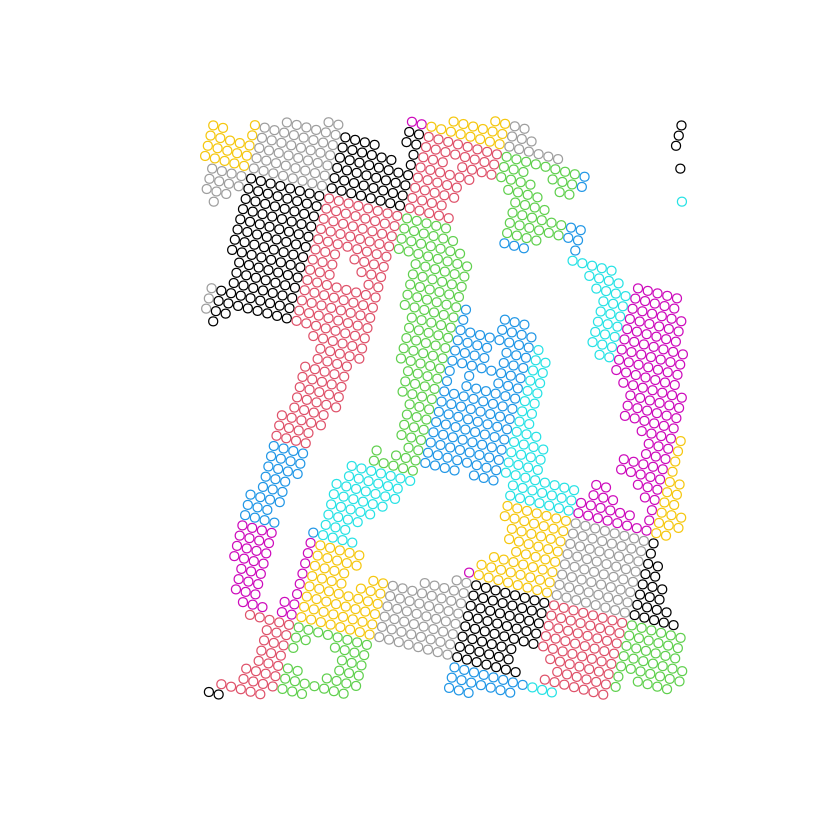

In [26]:
#Print a plot of the release coordinates to double check that it contains the correct area
plot(release_coords$coords,col=as.factor(release_coords$release_flat))

In [27]:
#Import study sites
at_sites<-read_csv('all_Atenuis_sites_FIXED.csv',show_col_types = FALSE)

In [28]:
#Convert study sites to sf object and create coordinates geography
at_sites$coords<-st_geometry(st_as_sf(at_sites,coords = c("LONGITUDE","LATITUDE")))

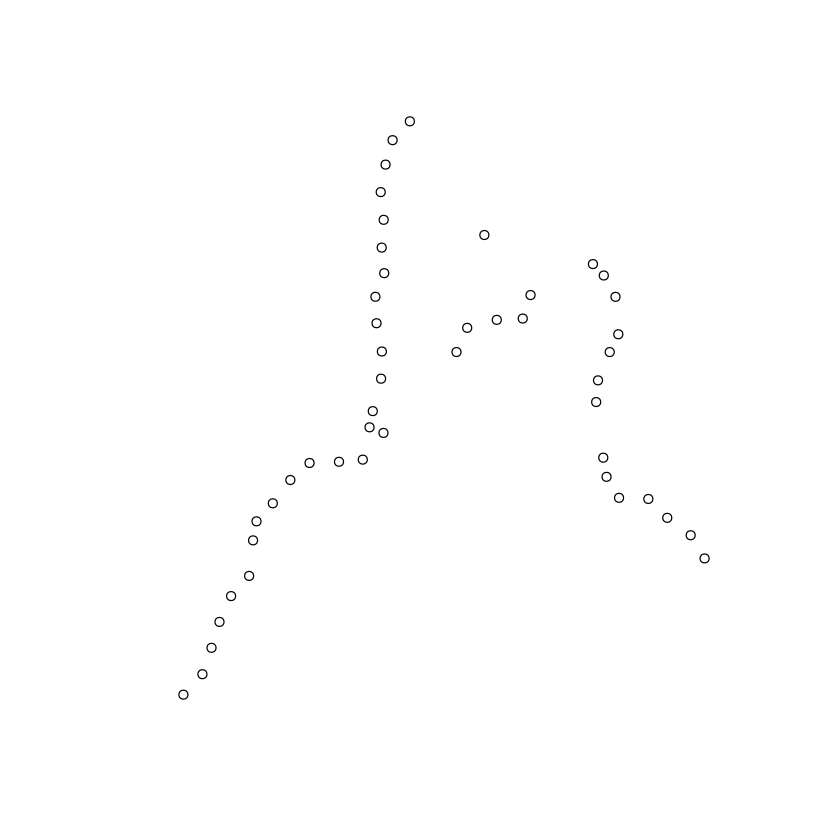

In [29]:
#Print a plot of the study coordinates to double check that it contains the correct area
plot(at_sites$coords)

In [30]:
#Create column of nearest release sites corresponding to each sampling site
at_sites$release_site<-apply(at_sites,FUN=mindist_match,release_all=release_coords,MARGIN=1)

In [31]:
#Create rownames and column names for connectivity data that correspond to the release sites names
colnames(connect_data)<-as.character(seq(1,2947))
rownames(connect_data)<-as.character(seq(1,2947))

In [32]:
#Create column on connectivity data corresponding to first release site
connect_data$release_siteA<-as.character(seq(1,2947))

In [33]:
#Pivot connectivity data to long form with columns corresponding to names of release sites
con_long<-pivot_longer(connect_data,cols=colnames(connect_data)[1:2947],names_to="release_siteB",values_to="connectivity")

In [34]:
#Import FST data
fst1<-read_csv('fst_1.csv',show_col_types = FALSE)
fst2<-read_csv('fst_2.csv',show_col_types = FALSE)
fst3<-read_csv('fst_3.csv',show_col_types = FALSE)
fst4<-read_csv('fst_4.csv',show_col_types = FALSE)

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


In [35]:
#Create two identical dataframes of corresponding sampling and release sites with different column names for next step
at_sitesA<-at_sites[,c('Name','release_site')]
colnames(at_sitesA)<-c('siteA','release_siteA')
at_sitesB<-at_sites[,c('Name','release_site')]
colnames(at_sitesB)<-c('siteB','release_siteB')

In [36]:
#Create long form datasets of pairwise FSTs and release site pairs
fst1_long<-fst_transform(fst1,at_sitesA,at_sitesB)
fst2_long<-fst_transform(fst2,at_sitesA,at_sitesB)
fst3_long<-fst_transform(fst3,at_sitesA,at_sitesB)
fst4_long<-fst_transform(fst4,at_sitesA,at_sitesB)

In [37]:
#Add column to long form connectivity data that is ID for release site *pairs*
con_long$release<-paste(con_long$release_siteA,con_long$release_siteB)

In [38]:
#Join FSTs and connectivity data by release site pairs. 
#Note that multiple FSTs pairs will have the same release site pair, due to the relatively gross spatial grain of the connectivity data
fst1_ocean<-fst_oceanography(fst1_long,con_long)
fst2_ocean<-fst_oceanography(fst2_long,con_long)
fst3_ocean<-fst_oceanography(fst3_long,con_long)
fst4_ocean<-fst_oceanography(fst4_long,con_long)

In [39]:
#LM of pariwise FST from connectivity, taxa1
summary(lm(fst ~ connectivity, fst1_ocean))


Call:
lm(formula = fst ~ connectivity, data = fst1_ocean)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.069420 -0.009725 -0.000538  0.006344  0.073817 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.0005394  0.0006092   0.885   0.3761   
connectivity -0.0279278  0.0107979  -2.586   0.0098 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01928 on 1330 degrees of freedom
Multiple R-squared:  0.005005,	Adjusted R-squared:  0.004256 
F-statistic: 6.689 on 1 and 1330 DF,  p-value: 0.009804


In [40]:
#LM of pariwise FST from connectivity, taxa2
summary(lm(fst ~ connectivity, fst2_ocean))


Call:
lm(formula = fst ~ connectivity, data = fst2_ocean)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.062956 -0.006303  0.000037  0.006841  0.040693 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)  -4.298e-05  5.809e-04  -0.074    0.941
connectivity  1.020e-02  8.911e-03   1.145    0.253

Residual standard error: 0.0127 on 648 degrees of freedom
Multiple R-squared:  0.002019,	Adjusted R-squared:  0.0004788 
F-statistic: 1.311 on 1 and 648 DF,  p-value: 0.2527


In [41]:
#LM of pariwise FST from connectivity, taxa3
summary(lm(fst ~ connectivity, fst3_ocean))


Call:
lm(formula = fst ~ connectivity, data = fst3_ocean)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08922 -0.02536 -0.01913 -0.00129  0.40532 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.02251    0.00303   7.429 2.77e-13 ***
connectivity -0.14455    0.05164  -2.799  0.00525 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0749 on 810 degrees of freedom
Multiple R-squared:  0.009579,	Adjusted R-squared:  0.008357 
F-statistic: 7.834 on 1 and 810 DF,  p-value: 0.005248


In [42]:
#LM of pariwise FST from connectivity, taxa4
summary(lm(fst ~ connectivity, fst4_ocean))


Call:
lm(formula = fst ~ connectivity, data = fst4_ocean)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.135267 -0.016789 -0.004264  0.010765  0.111047 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.004002   0.001367   2.928  0.00351 **
connectivity 0.066875   0.027535   2.429  0.01537 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03396 on 810 degrees of freedom
Multiple R-squared:  0.00723,	Adjusted R-squared:  0.006004 
F-statistic: 5.899 on 1 and 810 DF,  p-value: 0.01537


#Create wide form datasets of connectivity and FSTs for each taxon


In [45]:
#Create wide form datasets of connectivity and FSTs for each taxon
ocean1_wide<-wide_fst(fst1_ocean)
fst1_wide<-matavg(wide_ocean(fst1_ocean))

ocean2_wide<-wide_fst(fst2_ocean)
fst2_wide<-matavg(wide_ocean(fst2_ocean))

ocean3_wide<-wide_fst(fst3_ocean)
fst3_wide<-matavg(wide_ocean(fst3_ocean))

ocean4_wide<-wide_fst(fst4_ocean)
fst4_wide<-matavg(wide_ocean(fst4_ocean))

In [44]:
#Mantel test, taxa 1
mantel(fst1_wide,ocean1_wide,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst1_wide, ydis = ocean1_wide, method = "pearson",      na.rm = TRUE) 

Mantel statistic r: -0.07444 
      Significance: 0.844 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0957 0.1171 0.1388 0.1624 
Permutation: free
Number of permutations: 999


In [44]:
#Mantel test, taxa 2
mantel(fst2_wide,ocean2_wide,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst2_wide, ydis = ocean2_wide, method = "pearson",      na.rm = TRUE) 

Mantel statistic r: 0.04713 
      Significance: 0.271 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0986 0.1225 0.1482 0.1669 
Permutation: free
Number of permutations: 999


In [45]:
#Mantel test, taxa 3
mantel(fst3_wide,ocean3_wide,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst3_wide, ydis = ocean3_wide, method = "pearson",      na.rm = TRUE) 

Mantel statistic r: -0.1027 
      Significance: 0.88 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.128 0.146 0.159 0.178 
Permutation: free
Number of permutations: 999


In [46]:
#Mantel test, taxa 4
mantel(fst4_wide,ocean4_wide,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst4_wide, ydis = ocean4_wide, method = "pearson",      na.rm = TRUE) 

Mantel statistic r: 0.09204 
      Significance: 0.099 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0901 0.1219 0.1538 0.1772 
Permutation: free
Number of permutations: 999


In [47]:
#Write CSV of release sites corresponding to sampling sites
write_csv(at_sites,'atenuis_sampling_release_sites.csv')

The upper half of this script uses pairwise FSTs calculated at the spatial grain of the sampling sites -
however, this results in identical pairwise connectivity values for some of the pairwise FSTs, 
because the ROMs model was run at coarser resolution than the sampling sites.
Here, we recalculate FSTs from pooled populations that correspond to the resolution of the ROMs model release sites and therefore the connectivity data

In [62]:
#Read in VCFs of filtered SNPs for each taxon
spp1<-read.vcfR("/hb/scratch/jbos/spp1/snps_filtered_depth.recode.vcf")
spp2<-read.vcfR("/hb/scratch/jbos/spp2b/snps_filtered_depth.recode.vcf")
spp3<-read.vcfR("/hb/scratch/jbos/spp3/snps_filtered_depth.recode.vcf")
spp4<-read.vcfR("/hb/scratch/jbos/spp4/snps_filtered_depth.recode.vcf")

Scanning file to determine attributes.
File attributes:
  meta lines: 1605
  header_line: 1606
  variant count: 2218
  column count: 133
Meta line 1605 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 2218
  Character matrix gt cols: 133
  skip: 0
  nrows: 2218
  row_num: 0
Processed variant: 2218
All variants processed
Scanning file to determine attributes.
File attributes:
  meta lines: 1605
  header_line: 1606
  variant count: 1996
  column count: 82
Meta line 1605 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 1996
  Character matrix gt cols: 82
  skip: 0
  nrows: 1996
  row_num: 0
Processed variant: 1996
All variants processed
Scanning file to determine attributes.
File attributes:
  meta lines: 1605
  header_line: 1606
  variant count: 2421
  column count: 69
Meta line 1605 read in.
All meta lines processed.
gt matrix initialized.
Character matrix 

In [63]:
#Convert to genind
genind1 <- vcfR2genind(spp1)
genind2 <- vcfR2genind(spp2)
genind3 <- vcfR2genind(spp3)
genind4 <- vcfR2genind(spp4)

In [64]:
#Create dataframe/key of site names that correspond to each release site
site_dict<-at_sites[,c('Name','release_site')]

In [65]:
#Create a vector of release site names for each taxon in order to assign population in genind
pop1<-popmap(as.factor(unlist(lapply(strsplit(rownames(genind1$tab),"_"), head, 1))))
pop2<-popmap(as.factor(unlist(lapply(strsplit(rownames(genind2$tab),"_"), head, 1))))
pop3<-popmap(as.factor(unlist(lapply(strsplit(rownames(genind3$tab),"_"), head, 1))))
pop4<-popmap(as.factor(unlist(lapply(strsplit(rownames(genind4$tab),"_"), head, 1))))

In [66]:
#Assign population within each genind based on nearest release site for each individual
genind1@pop <-pop1
genind2@pop <-pop2
genind3@pop <-pop3
genind4@pop <-pop4

In [95]:
#Convert genind to hierfstat
hstat1<-genind2hierfstat(genind1,pop=genind1@pop)
hstat2<-genind2hierfstat(genind2,pop=genind2@pop)
hstat3<-genind2hierfstat(genind3,pop=genind3@pop)
hstat4<-genind2hierfstat(genind4,pop=genind4@pop)

In [96]:
#Calculate pairwise FSTs based on release sites for taxon 1, and convert to linearized FST
fst_1<-pairwise.WCfst(hstat1)
fst1a <- fst_1/(1-fst_1)

In [97]:
#Calculate pairwise FSTs based on release sites for taxon 2, and convert to linearized FST
fst_2<-pairwise.WCfst(hstat2)
fst2a <- fst_2/(1-fst_2)

In [98]:
#Calculate pairwise FSTs based on release sites for taxon 3, and convert to linearized FST
fst_3<-pairwise.WCfst(hstat3)
fst3a <- fst_3/(1-fst_3)

In [99]:
#Calculate pairwise FSTs based on release sites for taxon 4, and convert to linearized FST
fst_4<-pairwise.WCfst(hstat4)
fst4a <- fst_4/(1-fst_4)

In [64]:
write_csv(as.data.frame(fst_1),'connectivity_fsts1.csv')
write_csv(as.data.frame(fst_2),'connectivity_fsts2.csv')
write_csv(as.data.frame(fst_3),'connectivity_fsts3.csv')
write_csv(as.data.frame(fst_4),'connectivity_fsts4.csv')

In [53]:
fst_1<-read.csv('connectivity_fsts1.csv',check.names = FALSE)
rownames(fst_1) <- colnames(fst_1)
fst1a <- fst_1/(1-fst_1)
fst_2<-read.csv('connectivity_fsts2.csv',check.names = FALSE)
rownames(fst_2) <- colnames(fst_2)
fst2a <- fst_2/(1-fst_2)
fst_3<-read.csv('connectivity_fsts3.csv',check.names = FALSE)
rownames(fst_3) <- colnames(fst_3)
fst3a <- fst_3/(1-fst_3)
fst_4<-read.csv('connectivity_fsts4.csv',check.names = FALSE)
rownames(fst_4) <- colnames(fst_4)
fst4a <- fst_4/(1-fst_4)

In [66]:
#Calculate geographic distance between sites for downsampled data
#NOTE THAT THIS CODE NEEDS TO BE SIGNIFICANTLY CLEANED UP AND REWRITTEN AS FUNCTIONS - DON'T PUSH THIS NONSENSE TO GITHUB

In [58]:
#Create matrix of distances between sites, aggregated to grain of connectivity data
wide_dists1<-wide_release(release_coords,fst_1,release_flat)
wide_dists2<-wide_release(release_coords,fst_2,release_flat)
wide_dists3<-wide_release(release_coords,fst_3,release_flat)
wide_dists4<-wide_release(release_coords,fst_4,release_flat)

In [67]:
#Convert connectivity data to wide form and make symmetrical for Mantel tests
oc_1<-matavg(con_trans2(pop1))
oc_2<-matavg(con_trans2(pop2))
oc_3<-matavg(con_trans2(pop3))
oc_4<-matavg(con_trans2(pop4))

In [68]:
#Mantel test taxa 1 - oceanographic connectivity
mantel(fst1a,oc_1,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst1a, ydis = oc_1, method = "pearson", na.rm = TRUE) 

Mantel statistic r: -0.04962 
      Significance: 0.65 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.176 0.222 0.251 0.284 
Permutation: free
Number of permutations: 999


In [69]:
#Mantel test taxa 2 - oceanographic connectivity
mantel(fst2a,oc_2,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst2a, ydis = oc_2, method = "pearson", na.rm = TRUE) 

Mantel statistic r: -0.07946 
      Significance: 0.695 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.233 0.284 0.323 0.363 
Permutation: free
Number of permutations: 999


In [70]:
#Mantel test taxa 3 - oceanographic connectivity
mantel(fst3a,oc_3,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst3a, ydis = oc_3, method = "pearson", na.rm = TRUE) 

Mantel statistic r: 0.02855 
      Significance: 0.402 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.217 0.299 0.346 0.416 
Permutation: free
Number of permutations: 999


In [71]:
#Mantel test taxa 4 - oceanographic connectivity
mantel(fst4a,oc_4,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst4a, ydis = oc_4, method = "pearson", na.rm = TRUE) 

Mantel statistic r: -0.1939 
      Significance: 0.889 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.211 0.267 0.322 0.408 
Permutation: free
Number of permutations: 999


In [72]:
#Mantel test taxa 1 - resampled geographic distance
mantel(fst1a,wide_dists1,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst1a, ydis = wide_dists1, method = "pearson",      na.rm = TRUE) 

Mantel statistic r: -0.242 
      Significance: 0.822 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.258 0.293 0.332 0.377 
Permutation: free
Number of permutations: 999


In [73]:
#Mantel test taxa 2 - resampled geographic distance
mantel(fst2a,wide_dists2,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst2a, ydis = wide_dists2, method = "pearson",      na.rm = TRUE) 

Mantel statistic r: 0.2321 
      Significance: 0.14 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.276 0.368 0.402 0.467 
Permutation: free
Number of permutations: 999


In [74]:
#Mantel test taxa 3 - resampled geographic distance
mantel(fst3a,wide_dists3,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst3a, ydis = wide_dists3, method = "pearson",      na.rm = TRUE) 

Mantel statistic r: 0.05505 
      Significance: 0.393 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.279 0.359 0.423 0.505 
Permutation: free
Number of permutations: 999


In [75]:
#Mantel test taxa 4 - resampled geographic distance
mantel(fst4a,wide_dists4,method="pearson",na.rm=TRUE)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = fst4a, ydis = wide_dists4, method = "pearson",      na.rm = TRUE) 

Mantel statistic r: 0.2636 
      Significance: 0.134 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.290 0.347 0.389 0.454 
Permutation: free
Number of permutations: 999


In [76]:
#Partial Mantel test taxa 1
mantel.partial(fst1a,oc_1,wide_dists1,method="pearson",na.rm=TRUE)


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = fst1a, ydis = oc_1, zdis = wide_dists1,      method = "pearson", na.rm = TRUE) 

Mantel statistic r: -0.1099 
      Significance: 0.741 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.197 0.228 0.254 0.283 
Permutation: free
Number of permutations: 999


In [77]:
#Partial Mantel test taxa 2
mantel.partial(fst2a,oc_2,wide_dists2,method="pearson",na.rm=TRUE)


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = fst2a, ydis = oc_2, zdis = wide_dists2,      method = "pearson", na.rm = TRUE) 

Mantel statistic r: -0.02889 
      Significance: 0.566 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.223 0.291 0.339 0.401 
Permutation: free
Number of permutations: 999


In [78]:
#Partial Mantel test taxa 3
mantel.partial(fst3a,oc_3,wide_dists3,method="pearson",na.rm=TRUE)


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = fst3a, ydis = oc_3, zdis = wide_dists3,      method = "pearson", na.rm = TRUE) 

Mantel statistic r: 0.04204 
      Significance: 0.396 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.245 0.314 0.383 0.440 
Permutation: free
Number of permutations: 999


In [79]:
#Partial Mantel test taxa 4
mantel.partial(fst4a,oc_4,wide_dists4,method="pearson",na.rm=TRUE)


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = fst4a, ydis = oc_4, zdis = wide_dists4,      method = "pearson", na.rm = TRUE) 

Mantel statistic r: -0.1434 
      Significance: 0.81 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.237 0.296 0.361 0.437 
Permutation: free
Number of permutations: 999


In [80]:
#Make dataframes of individuals and corresponding populations
inds_per_pop1<-as.data.frame(cbind(rownames(genind1@tab),as.character(genind1@pop)))
colnames(inds_per_pop1)<-c("Individual","Population")

inds_per_pop2<-as.data.frame(cbind(rownames(genind2@tab),as.character(genind2@pop)))
colnames(inds_per_pop2)<-c("Individual","Population")

inds_per_pop3<-as.data.frame(cbind(rownames(genind3@tab),as.character(genind3@pop)))
colnames(inds_per_pop3)<-c("Individual","Population")

inds_per_pop4<-as.data.frame(cbind(rownames(genind4@tab),as.character(genind4@pop)))
colnames(inds_per_pop4)<-c("Individual","Population")

In [81]:
#Convert data back to long form and add a mean_counts column for mean individuals per population
long1<-long_again(fst1a,oc_1,inds_per_pop1)
long2<-long_again(fst2a,oc_2,inds_per_pop2)
long3<-long_again(fst3a,oc_3,inds_per_pop3)
long4<-long_again(fst4a,oc_4,inds_per_pop4)

Joining with `by = join_by(siteA, siteB)`
Joining with `by = join_by(siteA, siteB)`
Joining with `by = join_by(siteA, siteB)`
Joining with `by = join_by(siteA, siteB)`


In [82]:
fst_plot<-function(data,color,title,ul=0.5,xlabel=NULL,ylabel=NULL){
  pl<-ggplot(data, aes(x = as.numeric(connectivity), y = fst,size = mean_counts)) +
  geom_point(col=color,alpha =0.5) +
  geom_smooth(method = "lm",se=FALSE,col=color,show.legend = FALSE) +
  scale_size_continuous(name = "Mean samples per site pair", range = c(0.5, 0.5*max(data$mean_counts))) +
  annotate("text",x=0.1,y=0.02,label="R-squared=",size=6) +
  annotate("text",x=0.1,y=0.01,label=signif(summary(lm(fst~connectivity,dat=data))$adj.r.squared,digits=2),size=6)+
    xlab(xlabel) +
    ylab(ylabel) +
    theme_minimal() +
    ylim(-0.05, ul) + 
    xlim(-0.01, 0.2) + 
    theme(plot.title = element_text(size = 18),
          axis.title.x = element_text(size = 14),
          axis.title.y = element_text(size = 14),
          axis.text.x = element_text(size = 12),
          axis.text.y = element_text(size = 12),
          axis.ticks.y = element_blank(),
          axis.ticks.x= element_blank())
 return(pl) 
}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“The following aesthetics were dropped during statistical transformation: size.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


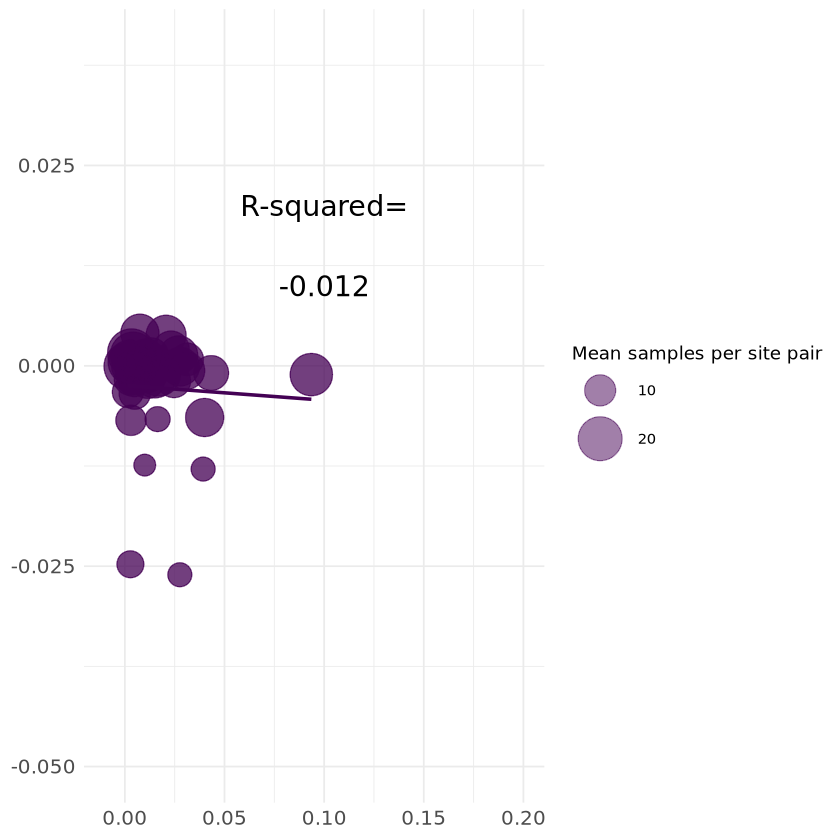

In [84]:
fst_plot(long1,"#440154FF",NULL,ul=0.04)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“The following aesthetics were dropped during statistical transformation: size.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


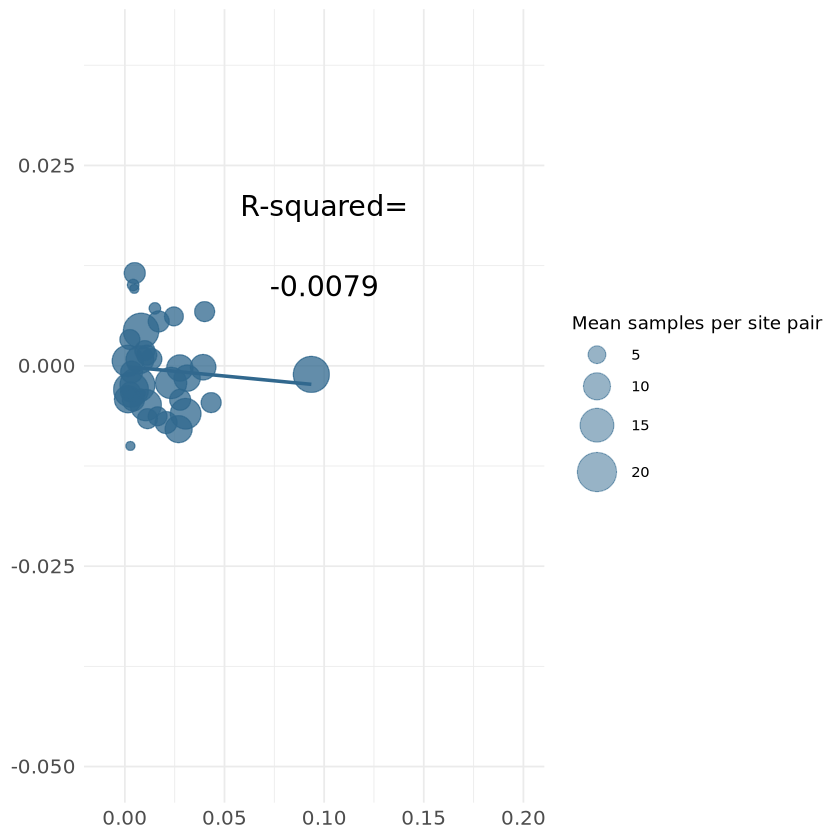

In [87]:
fst_plot(long2,"#31688EFF",NULL,ul=0.04)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“The following aesthetics were dropped during statistical transformation: size.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


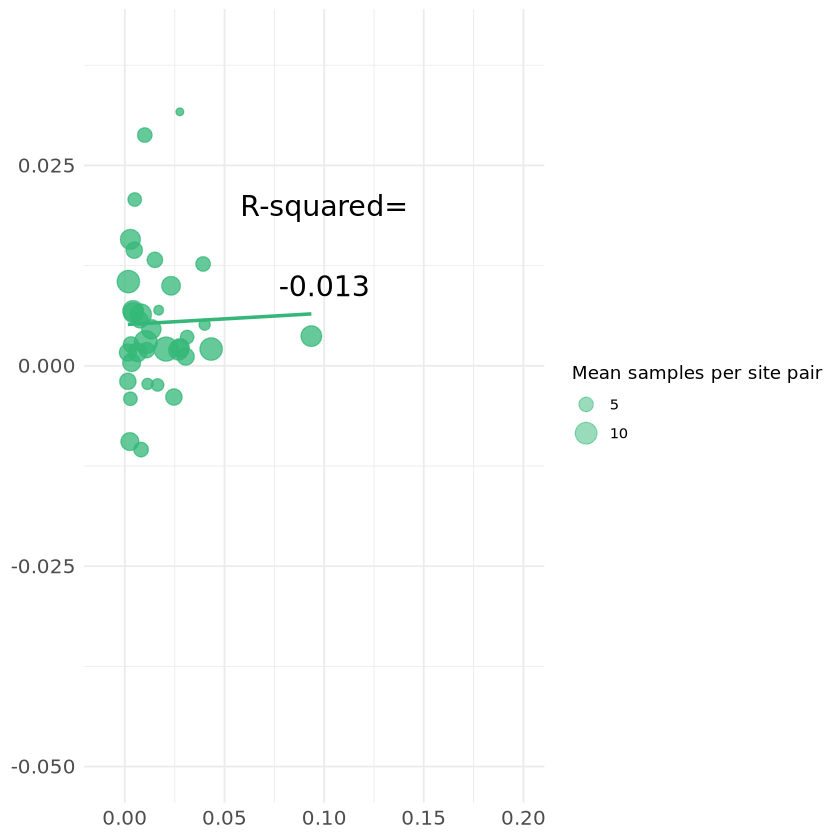

In [88]:
fst_plot(long3,"#35B779FF",NULL,ul=0.04)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“The following aesthetics were dropped during statistical transformation: size.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


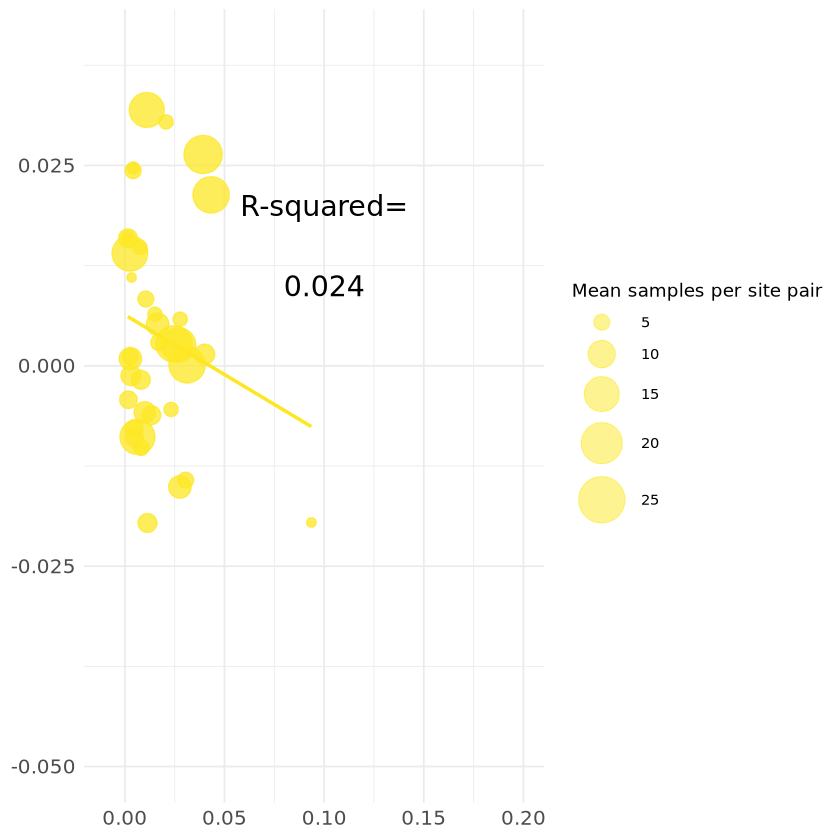

In [89]:
fst_plot(long4,"#FDE725FF",NULL,ul=0.04)

# 